In [1]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [3]:
%cd '/content/drive/MyDrive/Likhit/SignBoarding'

/content/drive/MyDrive/Likhit/SignBoarding


In [4]:
!pwd

/content/drive/MyDrive/Likhit/SignBoarding


In [5]:
import numpy as np 
import pandas as pd
import os
for folder in os.listdir('data/roadsData'):
  for file in os.listdir(f'data/roadsData/{folder}'):
    for img in os.listdir(f'data/roadsData/{folder}/{file}'):
      print(f'data/roadsData/{folder}/{file}/{img}')

data/roadsData/train/Plain/1.maxresdefault.jpg
data/roadsData/train/Plain/1.6.jpg
data/roadsData/train/Plain/1.Longeststraight0.jpg
data/roadsData/train/Plain/1.smooth_road_resize_md.jpg
data/roadsData/train/Plain/10.driving-on-country-roads-1.jpg
data/roadsData/train/Plain/1.jpg
data/roadsData/train/Plain/10.This-Is-the-Real-Difference-Between-Streets-Roads-and-Avenues_394392439-TTstudio-1024x684.jpg
data/roadsData/train/Plain/119.concrete-plan-cement-to-replace-asphalt-on-29-city-roads.jpg
data/roadsData/train/Plain/110.B88684391Z.1_20190426170311_000_G0DIRF0U.13-0_Super_Portrait.jpg
data/roadsData/train/Plain/120.Roads-Image.jpg
data/roadsData/train/Plain/12.4oyqr36qol221.jpg
data/roadsData/train/Plain/106.roads-43a.jpg
data/roadsData/train/Plain/109.image672f6274-35e3-426c-9a5c-97816c480584.jpg
data/roadsData/train/Plain/103.toll-roads-in-portugal.png
data/roadsData/train/Plain/124.Roads-surface-infrastructure-tarmac-620x330.jpg
data/roadsData/train/Plain/11.pageicon_home_150332515

In [6]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense


from keras.callbacks import ReduceLROnPlateau

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
# from keras.applications.resnet50 import ResNet50
# from keras.utils import to_categorical

# from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

In [7]:
IMG_SIZE=256
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [8]:
!pwd

/content/drive/MyDrive/Likhit/SignBoarding


In [9]:
X=[]
Z=[]
Plain='data/roadsData/train/Plain'
Pothole='data/roadsData/train/Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 357/357 [00:12<00:00, 28.60it/s]


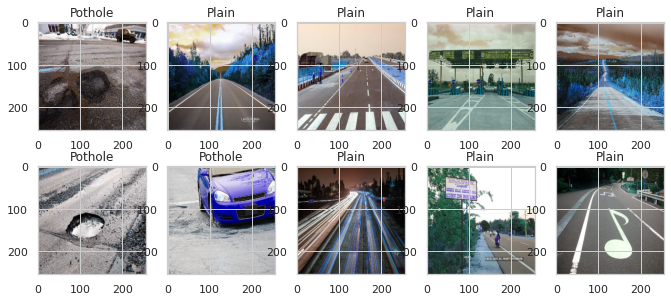

In [10]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [11]:
from keras.utils.np_utils import to_categorical
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
from keras.applications.resnet import ResNet50
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [13]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [14]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946
No

In [15]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
17/17 [==============================] - 30s 669ms/step - loss: 1.5154 - accuracy: 0.6784 - val_loss: 0.8745 - val_accuracy: 0.7182
Epoch 2/50
17/17 [==============================] - 7s 441ms/step - loss: 0.2489 - accuracy: 0.9094 - val_loss: 0.3780 - val_accuracy: 0.8785
Epoch 3/50
17/17 [==============================] - 8s 450ms/step - loss: 0.1238 - accuracy: 0.9482 - val_loss: 0.3468 - val_accuracy: 0.9061
Epoch 4/50
17/17 [==============================] - 8s 455ms/step - loss: 0.0635 - accuracy: 0.9686 - val_loss: 0.2684 - val_accuracy: 0.9227
Epoch 5/50
17/17 [==============================] - 8s 455ms/step - loss: 0.0322 - accuracy: 0.9871 - val_loss: 0.2455 - val_accuracy: 0.9282
Epoch 6/50
17/17 [==============================] - 8s 450ms/step - loss: 0.0395 - accuracy: 0.9852 - val_loss: 0.2041 - val_accuracy: 0.9337
Epoch 7/50
17/17 [==============================] - 8s 446ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 0.1937 - val_accuracy: 0.9448
Epoch

In [16]:
model.save('roadsModel.h5')

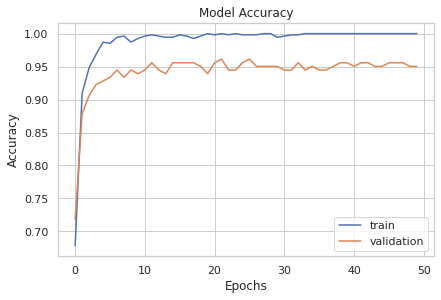

In [17]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

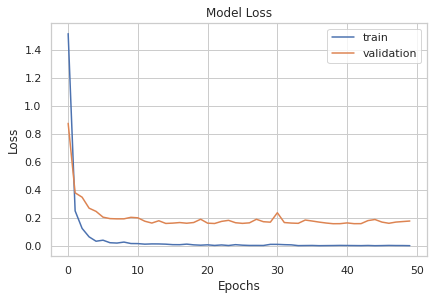

In [18]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [19]:
path = "data/roadsData/test/Pothole"
files = os.listdir(path)
files

['6.jpg', '8.jpg', '1.jpg', '7.jpg', '3.jpg', '2.jpg', '4.jpg', '5.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

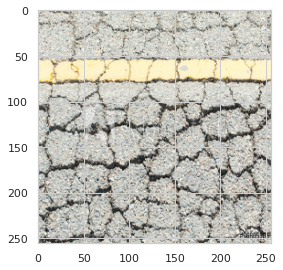

 12%|█▎        | 1/8 [00:01<00:13,  1.93s/it]

Pothole Road


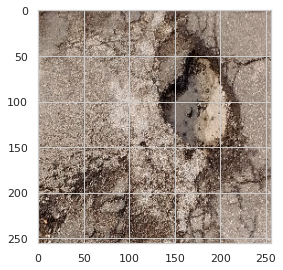

 25%|██▌       | 2/8 [00:02<00:06,  1.15s/it]

Pothole Road


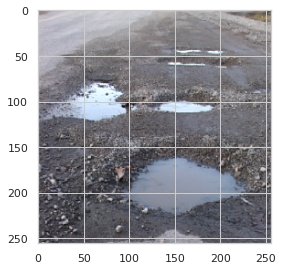

 38%|███▊      | 3/8 [00:03<00:04,  1.18it/s]

Pothole Road


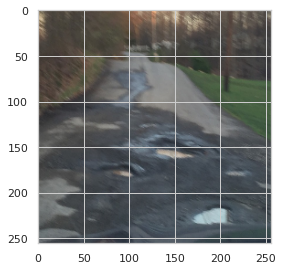

 50%|█████     | 4/8 [00:03<00:02,  1.42it/s]

Plain Road


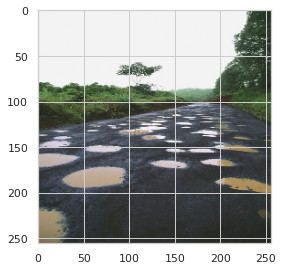

 62%|██████▎   | 5/8 [00:04<00:01,  1.53it/s]

Plain Road


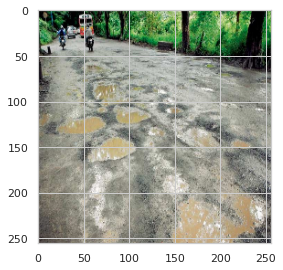

 75%|███████▌  | 6/8 [00:04<00:01,  1.57it/s]

Pothole Road


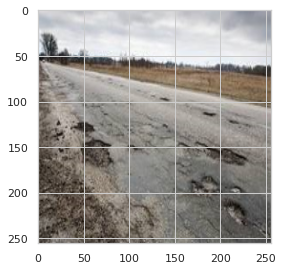

 88%|████████▊ | 7/8 [00:05<00:00,  1.59it/s]

Pothole Road


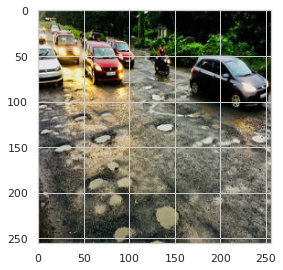

100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

Pothole Road


In [20]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

In [21]:
path = "data/roadsData/test/Plain"
files = os.listdir(path)
files

['1.jpg', '2.jpg', '4.jpg', '7.jpg', '3.jpg', '8.jpg', '5.jpg', '6.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

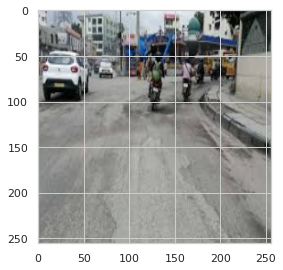

 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

Pothole Road


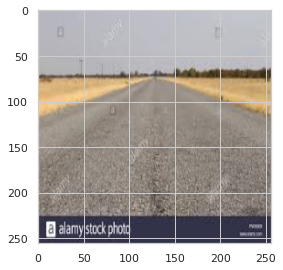

 25%|██▌       | 2/8 [00:01<00:03,  1.95it/s]

Plain Road


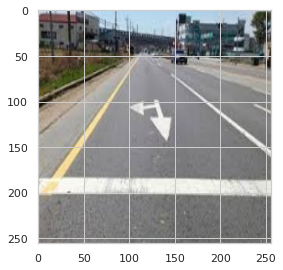

 38%|███▊      | 3/8 [00:01<00:02,  1.85it/s]

Plain Road


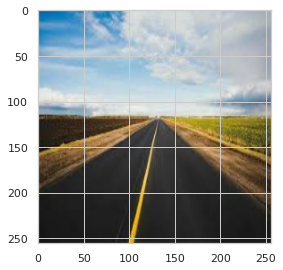

 50%|█████     | 4/8 [00:02<00:02,  1.85it/s]

Plain Road


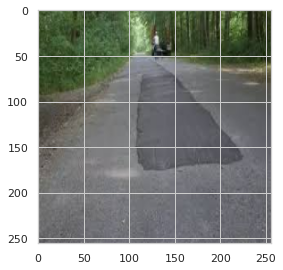

 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

Plain Road


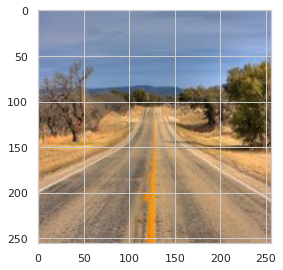

 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

Plain Road


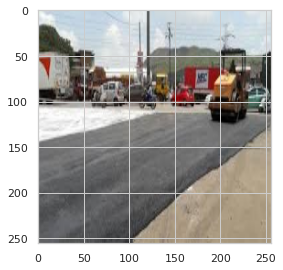

 88%|████████▊ | 7/8 [00:04<00:00,  1.24it/s]

Pothole Road


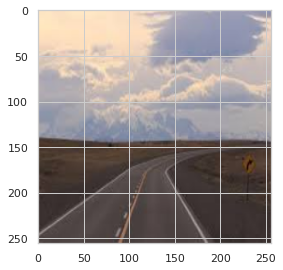

100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

Plain Road


In [22]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")